# Лабораторная работа 3
### Выполнил: Шаров Савелий Михайлович

Добро пожаловать в третью лабораторную работу! 
Оформите ваше решение контеста Kaggle в соответствии с этим шаблоном. Ваша задача - показать проверяющим ход ваших рассуждений, поэтому советуем писать много комментариев к коду и приводить комментарии к логике на каждом этапе в текстовых ячейках. 
Где необходимо, используйте графики для большей наглядности.

При отправке поменяйте название файла на ваши ФИО!

In [2]:
import numpy as np
import torch
import torch.nn as nn
import tqdm as tqdm
from torch.functional import F
import torch.optim as optim
import torchvision.transforms.v2 as tvt
import torchvision
from torchvision.transforms.functional import rotate, to_pil_image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from IPython.display import clear_output

# from ignite.engine import Engine, Events
# from ignite.handlers import FastaiLRFinder

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
import json

def download_contest3_data():
  !mkdir ~/.kaggle # закоментить если ругается
  !touch ~/.kaggle/kaggle.json # закоментить если ругается

  # токен надо сгенерировать в личном кабинете на kaggle (https://www.kaggle.com/settings/account)
  api_token = {"username":"savelysharov","key":"221dda3e8da3aaa017661167ccc9b2f7"}
  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle competitions download -c ml-mipt-2024-contest-3

  if not os.path.isdir("/kaggle/working/contest3"):
    !mkdir ./contest3

  !unzip ./ml-mipt-2024-contest-3.zip -d ./contest3

download_contest3_data()

### EDA (исследовательский анализ данных)

В этой лабораторной вы работаете с картинками. Напишите функцию, которая отрисовывала бы ключевые точки на конкретном изображении, это вам пригодится для дебага. 
Можете посчитать статистики по картинкам в датасете.

In [3]:
def show_img_with_points(sample):
    plt.imshow(sample['image'].permute(1, 2, 0))
    plt.scatter(sample['points'][:, 0], sample['points'][:, 1], s=10, marker='.', c='r')


### Preprocessing (подготовка данных)

Мы ожидаем, что в этом разделе вы реализуете кастомный класс для подгрузки данных (cоветуем унаследоваться от `torch.utils.data.Dataset`).

In [4]:
class CatDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.points = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.points)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_dir = os.path.join(self.root_dir, self.points.iloc[idx, -1])
        img = torchvision.io.read_image(img_dir)
        img_points = self.points.iloc[idx, :-1]
        img_points = np.array([img_points], dtype=np.float32).reshape(-1, 2)
        sample = {'image': img, 'points': img_points}
        if self.transform:
            sample = self.transform(sample)
        return sample


In [9]:
train_dataset = CatDataset('./images/images/train', './train_labels.csv')

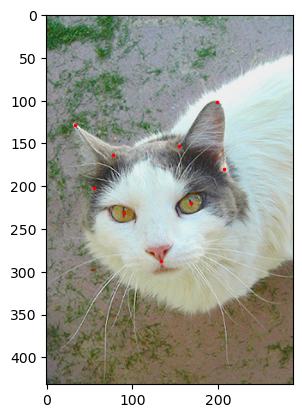

In [10]:
show_img_with_points(train_dataset[1])

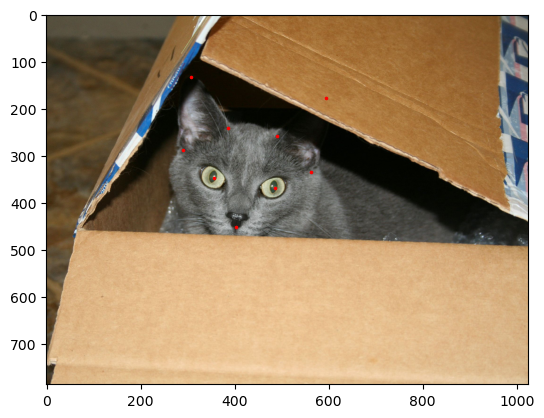

In [11]:
show_img_with_points(train_dataset[5])

Заметим, что изображения имеют разный размер. Стоит привести все картинки к одному разрешению.

Создаю кастомные трансформеры:

In [5]:
class Rescaler(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, sample):
        img, points = sample['image'], sample['points']
        h, w = img.shape[1:]
        if isinstance(self.size, int):
            if h > w:
                new_h, new_w = self.size * h / w, self.size
            else:
                new_h, new_w = self.size, self.size * w / h
        else:
            new_h, new_w = self.size
        new_h, new_w = int(new_h), int(new_w)
        img = tvt.Resize(size=(new_h, new_w))(img)
        points = points * [new_w / w, new_h / h]
        return {'image': img, 'points': points}

class RandomRotate(object):
    
    def __call__(self, sample):
        angel = 90 * np.random.randint(0, 4) # 0 - не вращать, 1 - 90 граудов, 2 - 180 градусов, 3 - 270 градусов
        image, points = sample['image'], sample['points']
        h, w = image.shape[1:]
        image = rotate(image, angel)
        if angel == 90:
            points = np.stack([points[:, 1], w - points[:, 0]], axis=-1)
        elif angel == 180:
            points = np.stack([w - points[:, 0], h - points[:, 1]], axis=-1)
        elif angel == 270:
            points = np.stack([h - points[:, 1], points[:, 0]], axis=-1)
        return {'image': image, 'points': points}

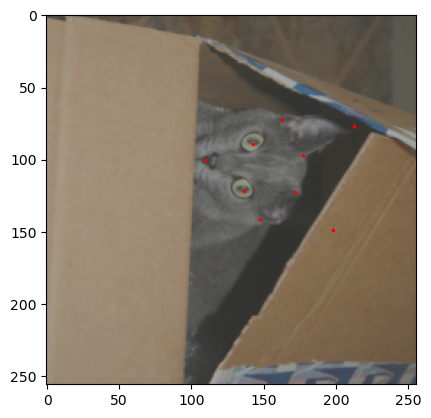

In [13]:
composed = tvt.Compose([Rescaler((256, 256)), RandomRotate(), tvt.ColorJitter(0.5,0.5)])

show_img_with_points(composed(train_dataset[5]))

### Training/evaluation loop

В этом разделе напишите функцию, принимающую модель, оптимизатор, кол-во эпох, и т.д, которая осуществляет обучение с заданными параметрами. Подумайте, что функция будет возвращать. 

Смысл этого раздела в том, чтобы не дублировать код обучения для каждого эксперимента. А еще на такую функцию легко накинуть перебор гиперпараметров... 

In [5]:
def stage(
    model: nn.Module,
    data: Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=train
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    for batch in tqdm.tqdm(loader):
        X = batch['image'].type(torch.float)
        Y = batch['points'].to(device)
        pred = model.forward(X.to(device))
        loss = F.l1_loss(pred, Y)
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
    return loss_sum / batches

def train(
    model: nn.Module,
    opt,
    train_data: Dataset,
    val_data: Dataset,
    batch_size: int = 256,
    epochs: int = 10,
    scheduler = None
):
    train_losses, val_losses = [], []
    min_metric, min_metric_epoch = float('inf'), 0
    for epoch in range(epochs):
        train_loss = stage(model, train_data, opt, batch_size=batch_size)
        val_loss = stage(model, val_data, opt, batch_size=batch_size, train=False)
        if scheduler:
            scheduler.step()
        if val_loss < min_metric:
            min_metric = val_loss
            min_metric_epoch = epoch + 1
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        clear_output()
        fig = plt.figure(figsize=(15, 7))
        plt.plot(np.arange(1, epoch + 2), train_losses, label='train')
        plt.plot(np.arange(1, epoch + 2), val_losses, label='val')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}.')
        print(f'Test loss {val_loss}.')
        print(f'Min validation metric {min_metric} in {min_metric_epoch} epoch')

### Prediction function

Реализуйте функцию, которая бы делала предсказания. Функция принимает датасет/даталоадер и модель (мб еще что-то). Эта функция нужна вам, чтобы было удобнее считать метрику (по сути она будет склеивать предсказания из батчей в один массив). 

In [7]:
class CatTestDataset(Dataset):
    def __init__(self, root_dir, img_size=(256, 256)):
        self.root_dir = root_dir
        self.img_paths = os.listdir(self.root_dir)
        self.img_size = img_size
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_dir = os.path.join(self.root_dir, self.img_paths[idx])
        img = torchvision.io.read_image(img_dir)
        img = tvt.Resize(self.img_size)(img)
        return img
    def get_image_name(self, idx):
        return self.img_paths[idx]

In [6]:
@torch.inference_mode()
def evaluate(model: nn.Module, data: DataLoader):
    model.eval()
    preds = []
    for batch in tqdm.tqdm(data):
        if isinstance(batch, dict):
            X = batch['image'].to(device)
        else:
            X = batch.to(device)
        X = X.type(torch.float)
        pred = model.forward(X)
        preds.append(pred.cpu().numpy())
    return np.concatenate(preds)

In [30]:
# функция для оценки предсказаний на валидации
def show_img_with_2points(sample, preds):
    plt.imshow(sample['image'].permute(1, 2, 0))
    plt.scatter(sample['points'][:, 0], sample['points'][:, 1], s=10, marker='.', c='r')
    plt.scatter(preds[:, 0], preds[:, 1], s=10, marker='.', c='b')

### Experiments

В этом разделе задаете архитектуры моделей и ставите эксперименты по обучению. Мы ожидаем, что вы зададите модель в виде класса (унаследуетесь от класса `torch.nn.Module`).

Если вы ставили много экспериментов, приведите их в хронологическом порядке, чтобы мы увидели эволюцию ваших рассуждений. 

Мы ожидаем увидеть графики train/val лоссов и метрик для ваших экспериментов. Мы ожидаем увидеть визуализацию примеров предсказаний. 

In [7]:
def AugmentData(root_dir, csv_file):
    """
    Функция для аугментации данных. 
    Она пропускает первые 500 тренировачных картинок, чтобы использовать их как валидацию. 
    К остальным она применяет случайный поворот и дважды меняет цветовую гамму. 
    3 новые картинки и 1 оригинальную она сохраняет в папку root_dir/augment.
    """
    labels = pd.read_csv(csv_file)
    aug_dir = os.path.join(root_dir, 'augment')
    os.makedirs(aug_dir)
    for i in range(500, len(labels)):
        img = torchvision.io.read_image(os.path.join(root_dir, labels.iloc[i, -1]))
        img_label = labels.iloc[i, :-1]
        img_label = np.array([img_label], dtype=np.float32).reshape(-1, 2)
        img_sample = {'image': img, 'points': img_label}
        img_sample = Rescaler((256, 256))(img_sample)
        rotated_sample = RandomRotate()(img_sample)
        rotated_img_name = labels.iloc[i,-1].split('.')[0] + 'aug_r.jpg'
        augmented_img1 = tvt.ColorJitter(0.5, 0.5)(img_sample['image'])
        augmented_img1_name = labels.iloc[i,-1].split('.')[0] + 'aug_c1.jpg'
        augmented_img2 = tvt.ColorJitter(0.25, 0.25)(img_sample['image'])
        augmented_img2_name = labels.iloc[i,-1].split('.')[0] + 'aug_c2.jpg'
        labels.loc[len(labels)] = [*rotated_sample['points'].flatten()] + [rotated_img_name]
        labels.loc[len(labels)] = [*img_sample['points'].flatten()] + [augmented_img1_name]
        labels.loc[len(labels)] = [*img_sample['points'].flatten()] + [augmented_img2_name]
        labels.iloc[i, :-1] = img_sample['points'].flatten()
        to_pil_image(img_sample['image']).save(os.path.join(aug_dir, labels.iloc[i,-1]))
        to_pil_image(rotated_sample['image']).save(os.path.join(aug_dir, rotated_img_name))
        to_pil_image(augmented_img1).save(os.path.join(aug_dir, augmented_img1_name))
        to_pil_image(augmented_img2).save(os.path.join(aug_dir, augmented_img2_name))
    labels.iloc[0:500].to_csv('./val_labels.csv', index=False)
    labels = labels.iloc[500:]
    labels = labels.reset_index(drop=True)
    labels.to_csv('./train_aug_labels.csv', index=False)

AugmentData('./images/images/train', './train_labels.csv')

In [8]:
train_dataset = CatDataset('./images/images/train/augment', './train_aug_labels.csv')
val_dataset = CatDataset('./images/images/train', './val_labels.csv', Rescaler((256, 256)))
test_dataset = CatTestDataset('./images/images/test')
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [97]:
models_results = pd.DataFrame(columns=['Model', 'CMAE'])

In [23]:
# Функция для подсчета обучаемых параметров сети
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Эксперимент 1

Возьмем в качестве baseline результат простой модели из 4 сверточных слоев и 3 полносвязных слоев для каждой группы точек.

In [20]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 32, 11, stride=4),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(3, stride=2))
        self.convblock2 = nn.Sequential(nn.Conv2d(32, 64, 5, padding='same'),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
                                nn.MaxPool2d(3, stride=2))
        self.convblock3 = nn.Sequential(nn.Conv2d(64, 128, 5, padding='same'),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
                                nn.MaxPool2d(3, stride=2))
        self.convblock4 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, 3, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2))
        self.dropout = nn.Dropout2d(p=0.4)
        self.left_ear = nn.Sequential(nn.Linear(256*2*2, 512),
                                       nn.LeakyReLU(),
                                       nn.Linear(512, 256),
                                       nn.LeakyReLU(),
                                       nn.Linear(256, 128),
                                       nn.LeakyReLU(),
                                       nn.Linear(128, 64),
                                       nn.LeakyReLU(),
                                       nn.Linear(64, 6))
        self.right_ear = nn.Sequential(nn.Linear(256*2*2, 512),
                                       nn.LeakyReLU(),
                                       nn.Linear(512, 256),
                                       nn.LeakyReLU(),
                                       nn.Linear(256, 128),
                                       nn.LeakyReLU(),
                                       nn.Linear(128, 64),
                                       nn.LeakyReLU(),
                                       nn.Linear(64, 6))
        self.face = nn.Sequential(nn.Linear(256*2*2, 512),
                                       nn.LeakyReLU(),
                                       nn.Linear(512, 256),
                                       nn.LeakyReLU(),
                                       nn.Linear(256, 128),
                                       nn.LeakyReLU(),
                                       nn.Linear(128, 64),
                                       nn.LeakyReLU(),
                                       nn.Linear(64, 6))
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = x.flatten(1)
        bs = x.shape[0]
        left_ear = self.left_ear(x).reshape(bs, 3, 2)
        right_ear = self.right_ear(x).reshape(bs, 3, 2)
        face = self.face(x).reshape(bs, 3, 2)
        x = torch.cat([face, left_ear, right_ear], 1)
        return x.reshape((bs, 9, 2))

In [21]:
net1 = Net1()
net1 = net1.to(device)
optimizer = optim.Adam(net1.parameters(), lr=1e-4)

In [24]:
print(f"The model has {count_parameters(net1):,} trainable parameters")

The model has 3,246,546 trainable parameters


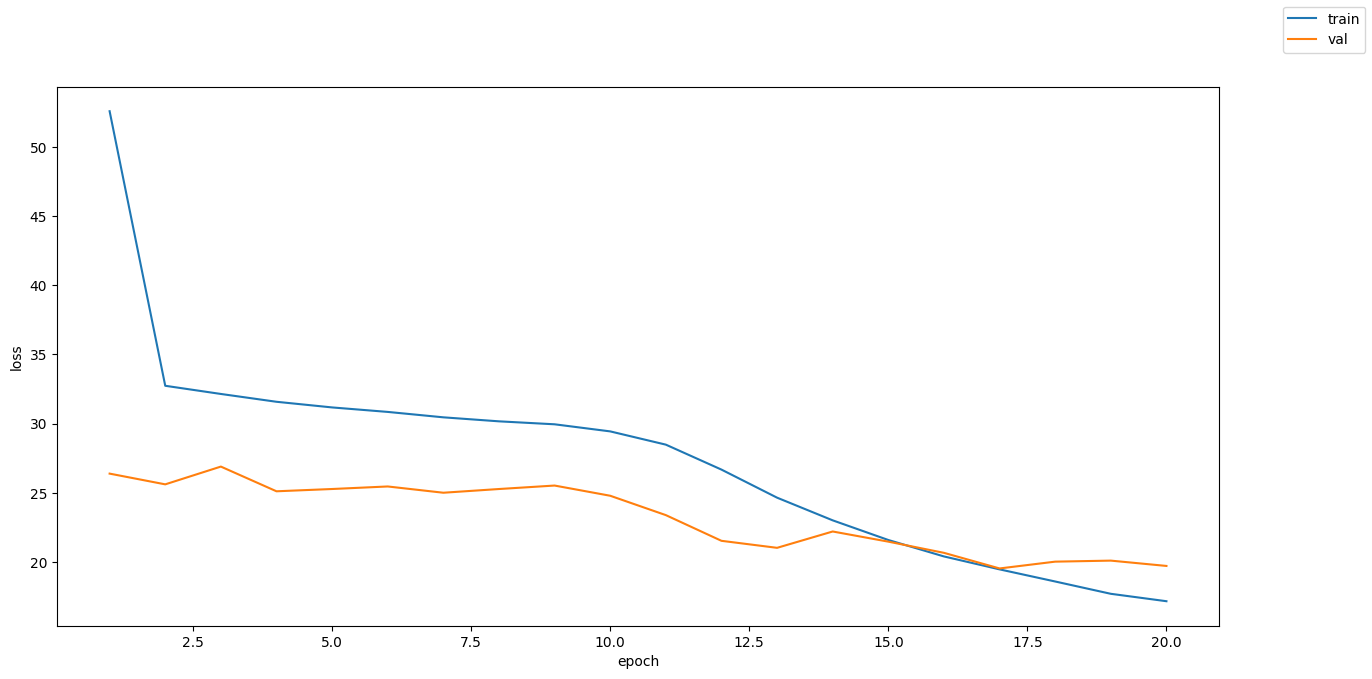

Epoch 20.
Train loss 17.14867585404475.
Test loss 19.700896147555557.
Min validation metric 19.51908528940435 in 17 epoch
CPU times: user 30min 5s, sys: 8min 46s, total: 38min 51s
Wall time: 23min 7s


In [30]:
%%time
train(net1, optimizer, train_dataset, val_dataset, epochs=20)

In [98]:
models_results.loc[len(models_results)] = pd.Series({'Model': 'Net1ep20', 'CMAE': 21.3531})

In [23]:
val_preds = evaluate(net1, val_loader)

100%|██████████| 2/2 [00:13<00:00,  6.51s/it]


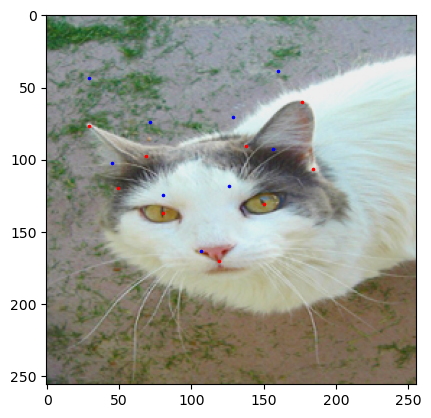

In [31]:
idx = 1
show_img_with_2points(val_dataset[idx], val_preds[idx])

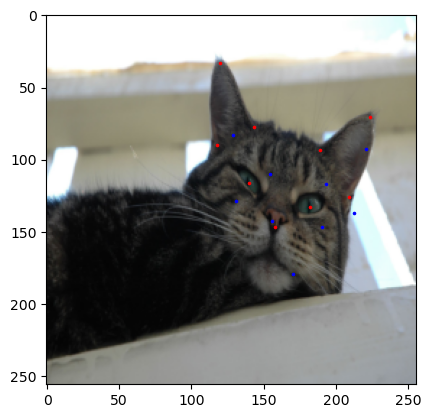

In [32]:
idx = 3
show_img_with_2points(val_dataset[idx], val_preds[idx])

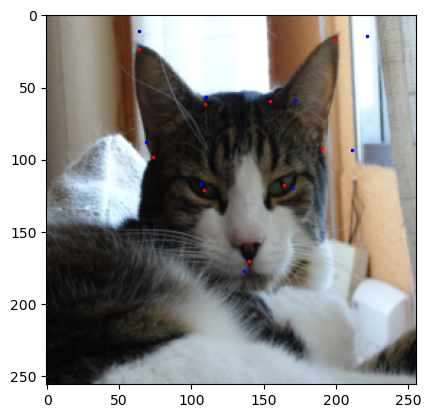

In [33]:
idx = 255
show_img_with_2points(val_dataset[idx], val_preds[idx])

#### Эксперимент 2

Пробую взять в качестве бекбона архитектуру AlexNet и обучить ее с нуля.

In [37]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 96, 11, stride=4),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(96),
                                        nn.MaxPool2d(3, stride=2))
        self.convblock2 = nn.Sequential(nn.Conv2d(96, 256, 5, padding=2),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(256),
                                        nn.MaxPool2d(3, stride=2))
        self.convblock3 = nn.Sequential(nn.Conv2d(256, 384, 3, padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(384, 384, 3, padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(384, 256, 3, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2))
        self.dropout = nn.Dropout(p=0.4)
        self.left_ear = nn.Sequential(nn.Linear(256*6*6, 1024),
                                       nn.LeakyReLU(),
                                       nn.Linear(1024, 512),
                                       nn.LeakyReLU(),
                                       nn.Linear(512, 256),
                                       nn.LeakyReLU(),
                                       nn.Linear(256, 64),
                                       nn.LeakyReLU(),
                                       nn.Linear(64, 32),
                                       nn.LeakyReLU(),
                                       nn.Linear(32, 6))
        self.right_ear = nn.Sequential(nn.Linear(256*6*6, 1024),
                                nn.LeakyReLU(),
                                nn.Linear(1024, 512),
                                nn.LeakyReLU(),
                                nn.Linear(512, 256),
                                nn.LeakyReLU(),
                                nn.Linear(256, 64),
                                nn.LeakyReLU(),
                                nn.Linear(64, 32),
                                nn.LeakyReLU(),
                                nn.Linear(32, 6))
        self.face = nn.Sequential(nn.Linear(256*6*6, 1024),
                                nn.LeakyReLU(),
                                nn.Linear(1024, 512),
                                nn.LeakyReLU(),
                                nn.Linear(512, 256),
                                nn.LeakyReLU(),
                                nn.Linear(256, 64),
                                nn.LeakyReLU(),
                                nn.Linear(64, 32),
                                nn.LeakyReLU(),
                                nn.Linear(32, 6))
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = x.flatten(1)
        x = self.dropout(x)
        bs = x.shape[0]
        left_ear = self.left_ear(x).reshape(bs, 3, 2)
        right_ear = self.right_ear(x).reshape(bs, 3, 2)
        face = self.face(x).reshape(bs, 3, 2)
        x = torch.cat([face, left_ear, right_ear], 1)
        return x.reshape((bs, 9, 2))

In [38]:
net2 = Net2()
net2 = net2.to(device)
optimizer = optim.Adam(net2.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataset) + len(val_dataset), epochs=40)

In [39]:
print(f"The model has {count_parameters(net2):,} trainable parameters")

The model has 34,087,090 trainable parameters


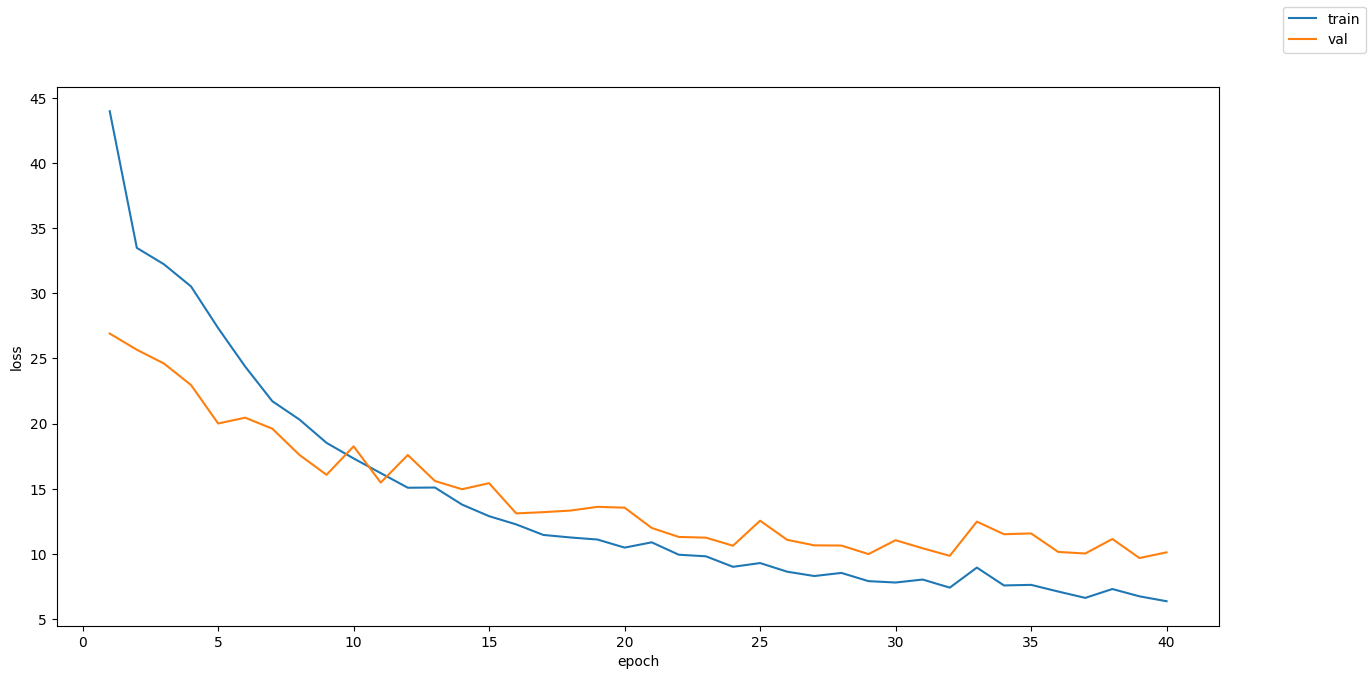

Epoch 40.
Train loss 6.374452263561647.
Test loss 10.122528276292178.
Min validation metric 9.688218136482678 in 39 epoch
CPU times: user 1h 3min 4s, sys: 17min 13s, total: 1h 20min 17s
Wall time: 57min 39s


In [14]:
%%time
train(net2, optimizer, train_dataset, val_dataset, batch_size=512, scheduler=scheduler, epochs=40)

In [99]:
models_results.loc[len(models_results)] = pd.Series({'Model': 'Net2ep40', 'CMAE': 9.6882})

In [43]:
val_preds = evaluate(net2, val_loader)

100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


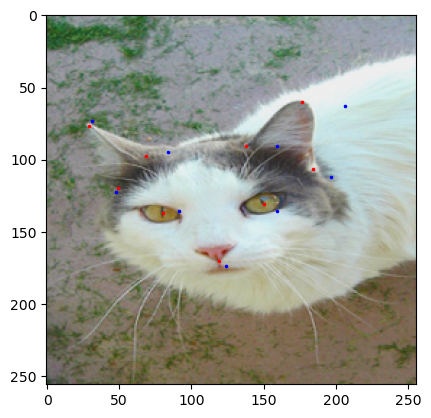

In [44]:
idx = 1
show_img_with_2points(val_dataset[idx], val_preds[idx])

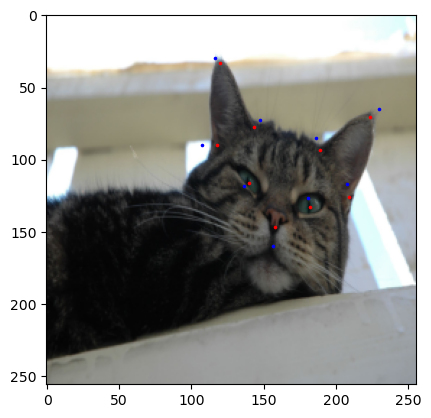

In [45]:
idx = 3
show_img_with_2points(val_dataset[idx], val_preds[idx])

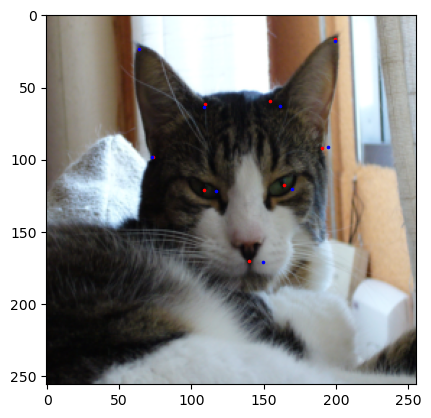

In [46]:
idx = 255
show_img_with_2points(val_dataset[idx], val_preds[idx])

#### Эксперимент 3

Попробуем поменять архитектуру бекбона на GoogLeNet. Я убрал 2 слоя Inception5 в конце свертки, с целью уменьшения размера нейронки.<br>
Так же я подаю на вход изображения с размером (224,224), как в оригинальной статье. 

In [47]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x


class InceptionBlock(nn.Module):
    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super().__init__()
        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)
        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)  
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)
        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)
         
    def forward(self, x):
        x1 = self.one_by_one(x)
        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)
        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)
        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)
        x = torch.cat([x1, x2, x3, x4], 1)
        return x


class Net3(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

        self.left_ear = nn.Sequential(nn.Linear(832, 512),
                                      nn.LeakyReLU(),
                                      nn.Linear(512, 256),
                                      nn.LeakyReLU(),
                                      nn.Linear(256, 64),
                                      nn.LeakyReLU(),
                                      nn.Linear(64, 6))
        self.right_ear = nn.Sequential(nn.Linear(832, 512),
                                nn.LeakyReLU(),
                                nn.Linear(512, 256),
                                nn.LeakyReLU(),
                                nn.Linear(256, 64),
                                nn.LeakyReLU(),
                                nn.Linear(64, 6))
        self.face = nn.Sequential(nn.Linear(832, 512),
                                nn.LeakyReLU(),
                                nn.Linear(512, 256),
                                nn.LeakyReLU(),
                                nn.Linear(256, 64),
                                nn.LeakyReLU(),
                                nn.Linear(64, 6))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        bs = x.shape[0]
        x = self.dropout(x)
        left_ear = self.left_ear(x).reshape(bs, 3, 2)
        right_ear = self.right_ear(x).reshape(bs, 3, 2)
        face = self.face(x).reshape(bs, 3, 2)
        x = torch.cat([face, left_ear, right_ear], 1)
        return x

In [72]:
net3_train_dataset = CatDataset('./images/images/train/augment', './train_aug_labels.csv', Rescaler((224, 224)))
net3_val_dataset = CatDataset('./images/images/train', './val_labels.csv', Rescaler((224, 224)))
net3_val_loader = DataLoader(net3_val_dataset, batch_size=256, shuffle=False)

In [48]:
net3 = Net3()
net3.to(device)
optimizer = optim.Adam(net3.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(net3_train_dataset) + len(net3_val_dataset), epochs=40)

In [50]:
print(f"The model has {count_parameters(net3):,} trainable parameters")

The model has 5,215,698 trainable parameters


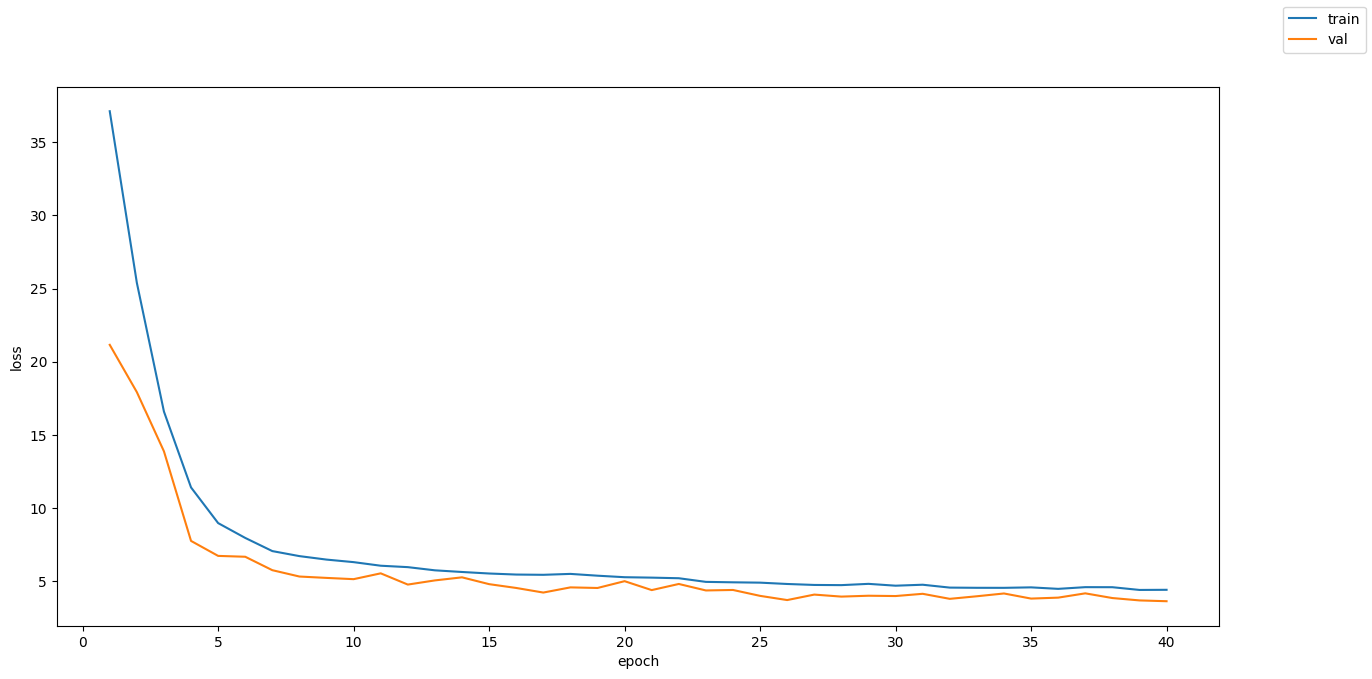

Epoch 40.
Train loss 4.391269232245053.
Test loss 3.6100659233149917.
Min validation metric 3.6100659233149917 in 40 epoch
CPU times: user 1h 34min 50s, sys: 11min 39s, total: 1h 46min 30s
Wall time: 1h 14min 14s


In [14]:
%%time
train(net3, optimizer, net3_train_dataset, net3_val_dataset, batch_size=200, epochs=40, scheduler=scheduler)

In [100]:
models_results.loc[len(models_results)] = pd.Series({'Model': 'Net3ep40', 'CMAE': 3.6100})

In [73]:
val_preds = evaluate(net3, net3_val_loader)

100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


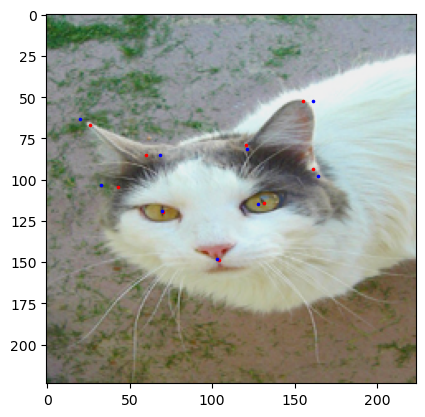

In [75]:
idx = 1
show_img_with_2points(net3_val_dataset[idx], val_preds[idx])

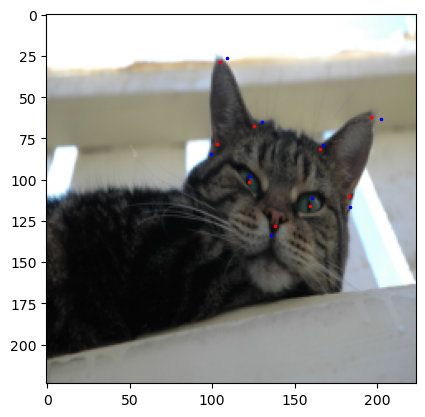

In [78]:
idx = 3
show_img_with_2points(net3_val_dataset[idx], val_preds[idx])

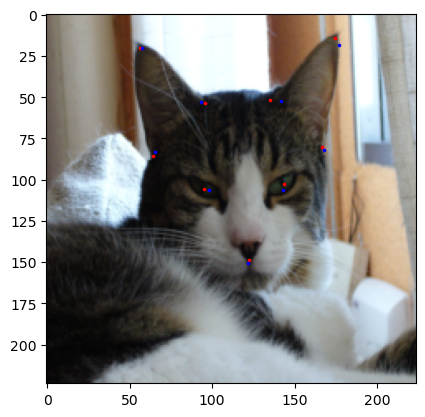

In [79]:
idx = 255
show_img_with_2points(net3_val_dataset[idx], val_preds[idx])

Видно, что новая архитектура дала большой прирост в точности.

#### Эксперимент 4

Попробую взять MSE в качестве функции потерь. Идея в том, что на сжатых изображения ошибка тоже сжимается. Я хочу попробовать штрафовать модель даже за небольшие отклонения.

Для этого я изменил функцию обучения:

In [ ]:
def stage(
    model: nn.Module,
    data: Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=train
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    for batch in tqdm.tqdm(loader):
        X = batch['image'].type(torch.float)
        Y = batch['points'].to(device)
        pred = model.forward(X.to(device))
        loss = F.l1_loss(pred, Y)
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
    return loss_sum / batches, F.l1_loss(pred, Y).cpu().data.numpy()

def train(
    model: nn.Module,
    opt,
    train_data: Dataset,
    val_data: Dataset,
    batch_size: int = 256,
    epochs: int = 10,
    scheduler = None
):
    train_losses, val_losses , train_metrics, val_metrics = [], [], [], []
    min_metric, min_metric_epoch = float('inf'), 0
    min_metric_model_sd, min_metric_optim_sd = model.state_dict(), opt.state_dict()
    for epoch in range(epochs):
        train_loss, train_metric = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_metric = stage(model, val_data, opt, batch_size=batch_size, train=False)
        if scheduler:
            scheduler.step()
        if val_loss < min_metric:
            min_metric = val_loss
            min_metric_epoch = epoch + 1
            min_metric_model_sd, min_metric_optim_sd = model.state_dict(), opt.state_dict()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append(train_metric)
        val_metrics.append(val_metric)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_metrics, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_metrics, label='val')
        axis[0].set(xlabel='epoch', ylabel='MSE Loss')
        axis[1].set(xlabel='epoch', ylabel='MAE')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train metric {train_metric}.')
        print(f'Test loss {val_loss}. Test metric {val_metric}')
        print(f'Min validation metric {min_metric} in {min_metric_epoch} epoch')

In [80]:
net4 = Net3()
net4.to(device)
optimizer = optim.Adam(net4.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(net3_train_dataset) + len(net3_val_dataset), epochs=40)

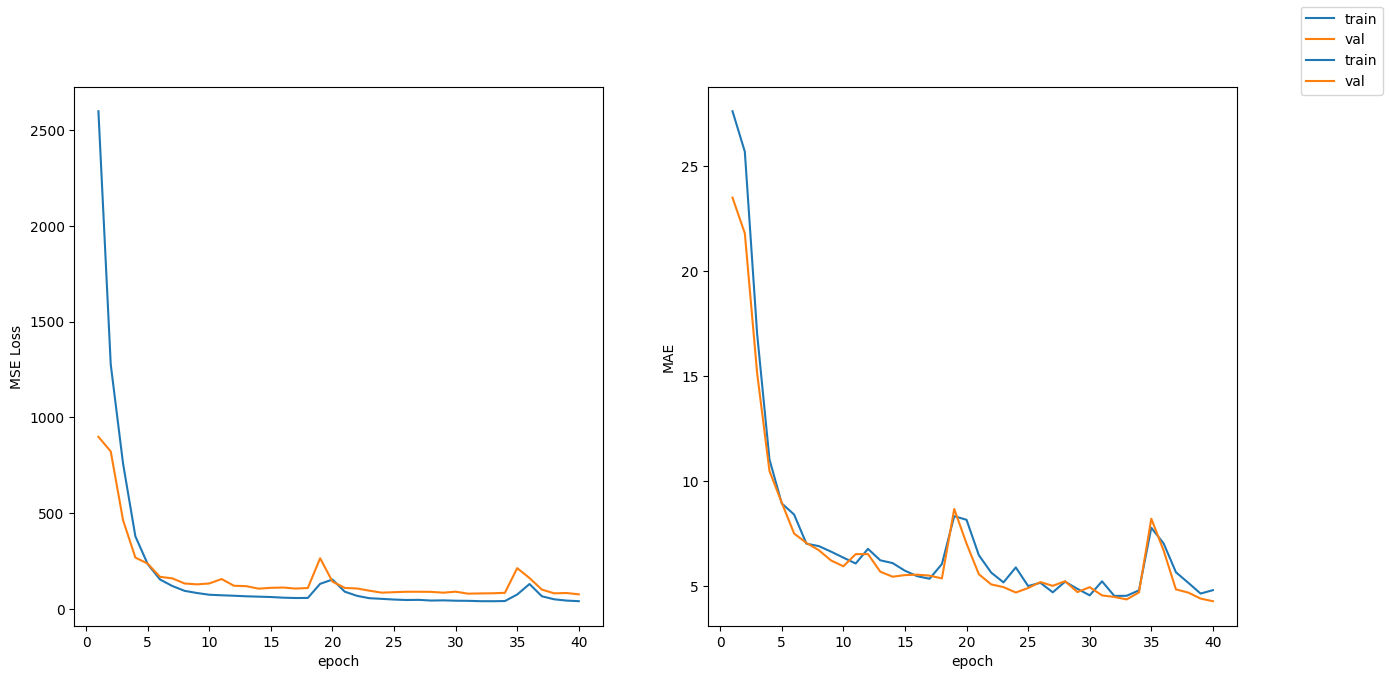

Epoch 40.
Train loss 40.284407200532804. Train metric 4.798839092254639.
Test loss 75.94459484023724. Test metric 4.271933795839722
CPU times: user 1h 34min 26s, sys: 12min 9s, total: 1h 46min 36s
Wall time: 1h 13min 54s


In [11]:
%%time
train(net4, optimizer, net3_train_dataset, net3_val_dataset, batch_size=200, epochs=40, scheduler=scheduler)

In [101]:
models_results.loc[len(models_results)] = pd.Series({'Model': 'Net3ep40_with_MSE', 'CMAE': 4.2719})

In [82]:
val_preds = evaluate(net4, net3_val_loader)

100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


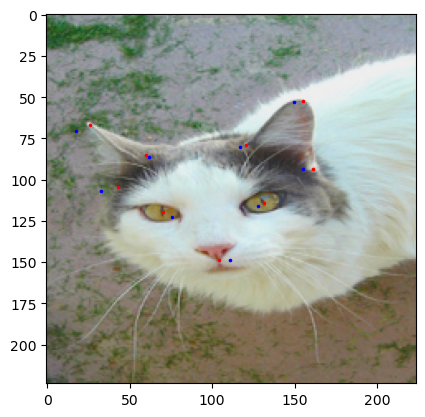

In [83]:
idx = 1
show_img_with_2points(net3_val_dataset[idx], val_preds[idx])

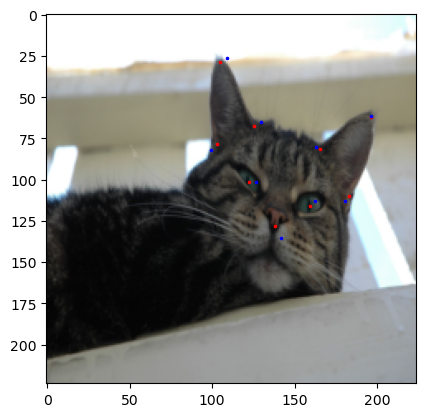

In [84]:
idx = 3
show_img_with_2points(net3_val_dataset[idx], val_preds[idx])

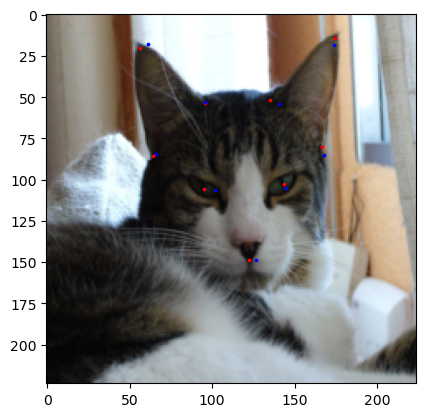

In [85]:
idx = 255
show_img_with_2points(net3_val_dataset[idx], val_preds[idx])

Видно, что с MAE в роли функции потерь модель работает лучше, чем с MSE.

Эксперимент 5

Так как архитектура GoogLeNet хорошо себя показала в предыдущем эксперименте, я пробую улучишить её, добавив skip-connection.<br> Для этого я взял в качестве бекбона Inception-ResNet v1, который обрезал до первых 4 сверточных блоков, чтобы уменьшить модель.

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, **kwargs)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class InceptionResnetA(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.scale = scale
        self.conv1x1 = ConvBlock(256, 32, 1)
        self.conv3x3 = nn.Sequential(ConvBlock(256, 32, 1),
                                     ConvBlock(32, 32, 3, padding=1))
        self.conv5x5 = nn.Sequential(ConvBlock(256, 32, 1),
                                     ConvBlock(32, 32, 3, padding=1),
                                     ConvBlock(32, 32, 3, padding=1))
        self.final_conv = nn.Conv2d(96, 256, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        out = torch.cat([x1, x2, x3], 1)
        out = self.final_conv(out)
        out = self.scale * out + x
        out = self.relu(out)
        return out

class InceptionResnetB(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.scale = scale
        self.conv1x1 = ConvBlock(896, 128, 1)
        self.conv7x7 = nn.Sequential(ConvBlock(896, 128, 1),
                                     ConvBlock(128, 128, (1, 7), padding=(0, 3)),
                                     ConvBlock(128, 128, (7, 1), padding=(3, 0)))
        self.final_conv = nn.Conv2d(256, 896, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv7x7(x)
        out = torch.cat([x1, x2], 1)
        out = self.final_conv(out)
        out = self.scale * out + x
        out = self.relu(out)
        return out

class ReductionA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv3x3 = ConvBlock(256, 384, 3, stride=2)
        self.conv5x5 = nn.Sequential(ConvBlock(256, 192, 1),
                                     ConvBlock(192, 192, 3, padding=1),
                                     ConvBlock(192, 256, 3, stride=2))
        self.pool = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        x1 = self.conv3x3(x)
        x2 = self.conv5x5(x)
        x3 = self.pool(x)
        out = torch.cat([x1, x2, x3], 1)
        return out

class Net4(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.stem = nn.Sequential(ConvBlock(in_channels, 32, kernel_size=3, stride=2),
                                  ConvBlock(32, 32, 3),
                                  ConvBlock(32, 64, 3, padding=1),
                                  nn.MaxPool2d(3, stride=2),
                                  ConvBlock(64, 80, 1),
                                  ConvBlock(80, 192, 3),
                                  ConvBlock(192, 256, 3, stride=2))
        self.inception_resnet_a = nn.Sequential(*[InceptionResnetA(0.17) for _ in range(5)])
        self.reduction_a = ReductionA()
        self.inception_resnet_b = nn.Sequential(*[InceptionResnetB(0.10) for _ in range(10)])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.4)

        self.left_ear = nn.Sequential(nn.Linear(896, 512),
                                      nn.LeakyReLU(),
                                      nn.Linear(512, 256),
                                      nn.LeakyReLU(),
                                      nn.Linear(256, 64),
                                      nn.LeakyReLU(),
                                      nn.Linear(64, 6))
        self.right_ear = nn.Sequential(nn.Linear(896, 512),
                                nn.LeakyReLU(),
                                nn.Linear(512, 256),
                                nn.LeakyReLU(),
                                nn.Linear(256, 64),
                                nn.LeakyReLU(),
                                nn.Linear(64, 6))
        self.face = nn.Sequential(nn.Linear(896, 512),
                                nn.LeakyReLU(),
                                nn.Linear(512, 256),
                                nn.LeakyReLU(),
                                nn.Linear(256, 64),
                                nn.LeakyReLU(),
                                nn.Linear(64, 6))

    def forward(self, x):
        x = self.stem(x)
        x = self.inception_resnet_a(x)
        x = self.reduction_a(x)
        x = self.inception_resnet_b(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.flatten(1)
        bs = x.shape[0]
        left_ear = self.left_ear(x).reshape(bs, 3, 2)
        right_ear = self.right_ear(x).reshape(bs, 3, 2)
        face = self.face(x).reshape(bs, 3, 2)
        x = torch.cat([face, left_ear, right_ear], 1)
        return x

In [87]:
net5 = Net4()
net5 = net5.to(device)
optimizer = optim.Adam(net5.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataset) + len(val_dataset), epochs=40)

In [88]:
print(f"The model has {count_parameters(net5):,} trainable parameters")

The model has 11,435,602 trainable parameters


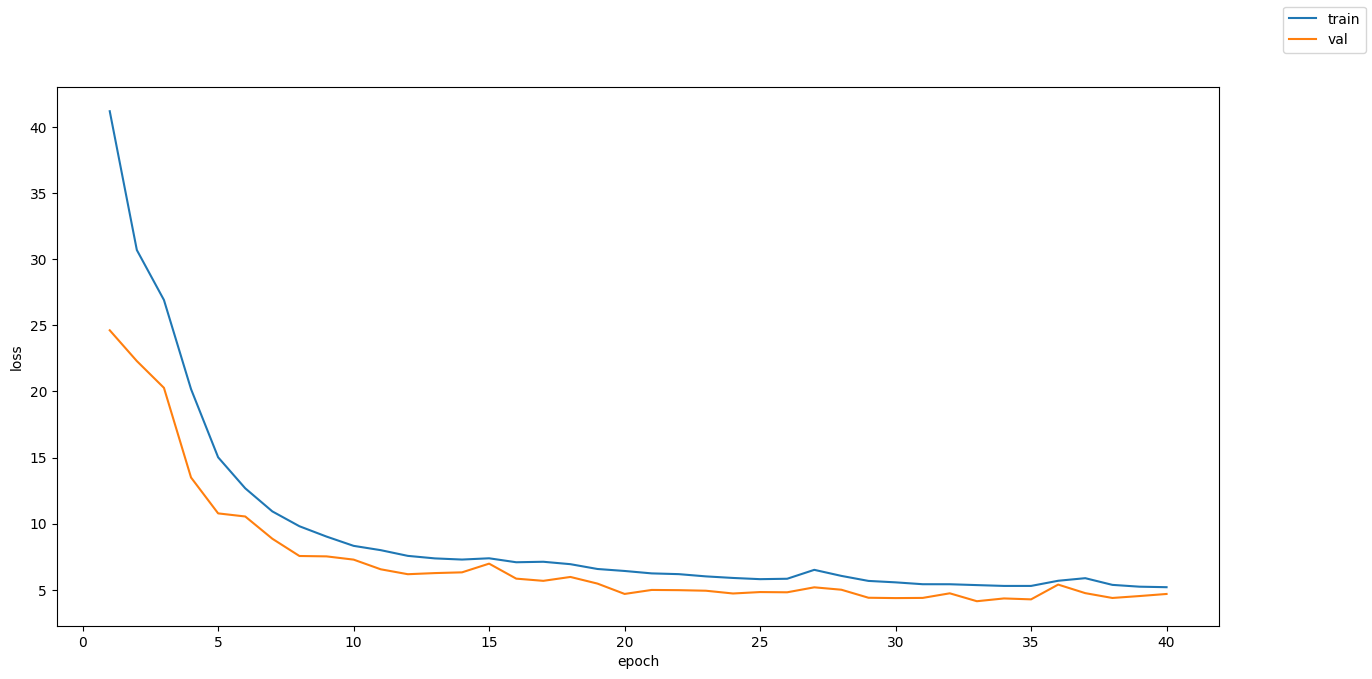

Epoch 40.
Train loss 5.191886079042478.
Test loss 4.679592404811439.
Min validation metric 4.130723365923064 in 33 epoch
CPU times: user 2h 43min 37s, sys: 27min 25s, total: 3h 11min 2s
Wall time: 2h 23min 10s


In [11]:
%%time
train(net5, optimizer, train_dataset, val_dataset, batch_size=128, epochs=40, scheduler=scheduler)

In [102]:
models_results.loc[len(models_results)] = pd.Series({'Model': 'Net4ep40', 'CMAE': 4.1307})

Так как моедль Net4 получилось большой, я пробую обучить её на большем количестве эпох:

In [10]:
net6 = Net4()
net6 = net6.to(device)
optimizer = optim.Adam(net6.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataset) + len(val_dataset), epochs=80)

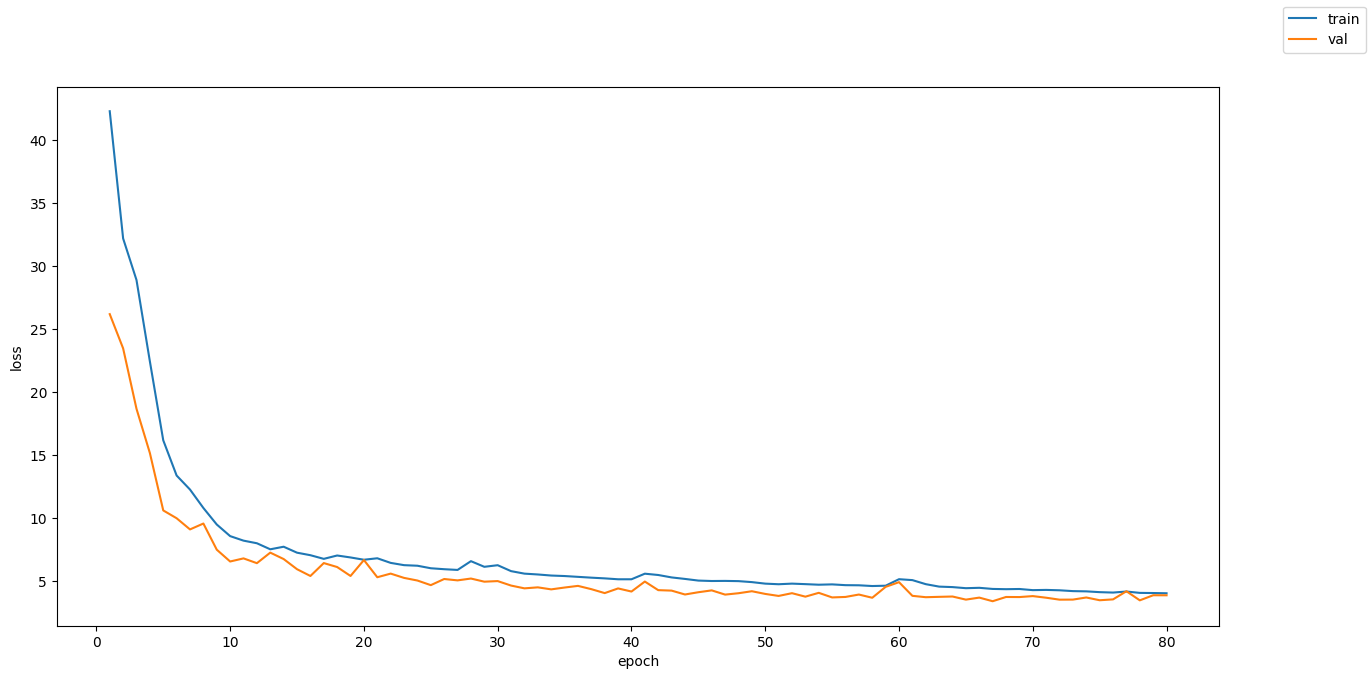

Epoch 80.
Train loss 4.009340132089486.
Test loss 3.848600360268019.
Min validation metric 3.3776371591326635 in 67 epoch
CPU times: user 5h 26min 32s, sys: 55min 5s, total: 6h 21min 38s
Wall time: 4h 45min 58s


In [22]:
%%time
model_sd, optim_sd = train(net6, optimizer, train_dataset, val_dataset, batch_size=128, epochs=80, scheduler=scheduler)

In [103]:
models_results.loc[len(models_results)] = pd.Series({'Model': 'Net4ep80', 'CMAE': 3.3776})

In [106]:
val_preds = evaluate(net6, val_loader)

100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


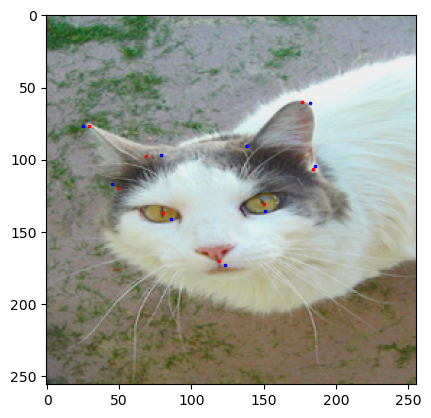

In [107]:
idx = 1
show_img_with_2points(val_dataset[idx], val_preds[idx])

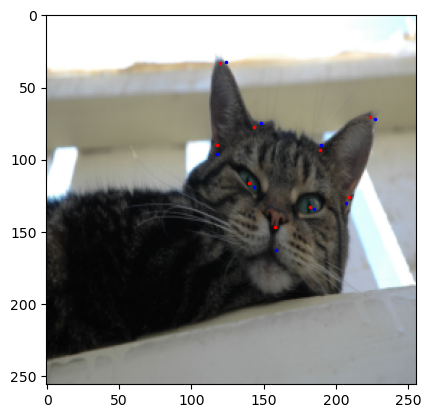

In [108]:
idx = 3
show_img_with_2points(val_dataset[idx], val_preds[idx])

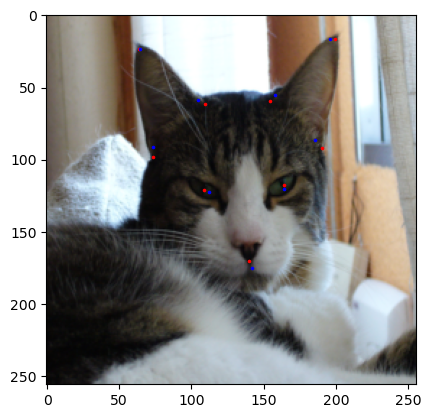

In [109]:
idx = 255
show_img_with_2points(val_dataset[idx], val_preds[idx])

In [104]:
models_results

Model     CMAE
0           Net1ep20  21.3531
1           Net2ep40   9.6882
2           Net3ep40     3.61
3  Net3ep40_with_MSE   4.2719
4           Net4ep40   4.1307
5           Net4ep80   3.3776

### Evaluation  (оценка качества модели)

В этом разделе проводите оценку качества вашей итоговой модели (с помощью prediction function из раздела выше). 

В качетве итоговой модели беру Net4 обученный на 80 эпохах

In [12]:
test_preds = evaluate(net6, test_loader)

100%|██████████| 4/4 [00:20<00:00,  5.01s/it]


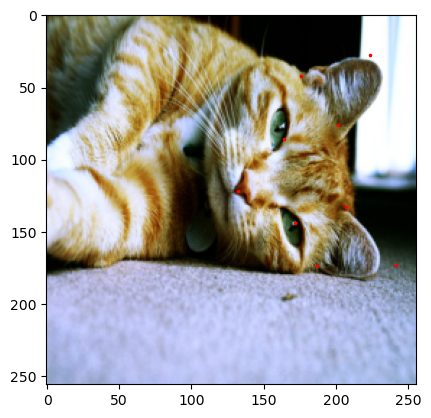

In [13]:
idx = 677
sample = {'image': test_dataset[idx], 'points': test_preds[idx]}
show_img_with_points(sample)

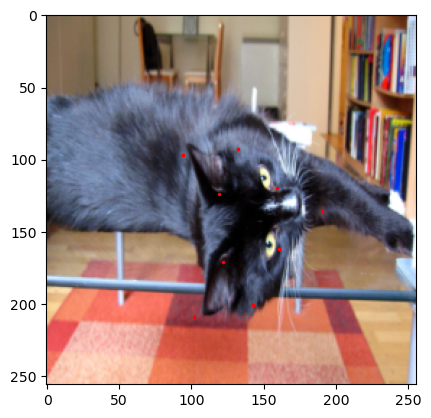

In [14]:
idx = 13
sample = {'image': test_dataset[idx], 'points': test_preds[idx]}
show_img_with_points(sample)

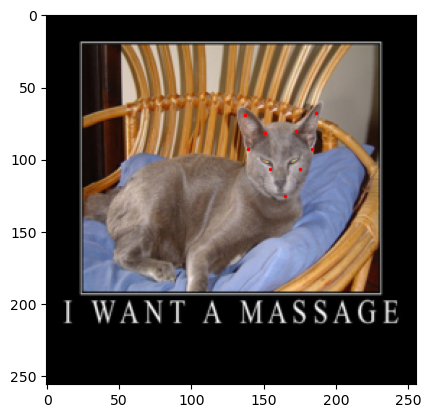

In [15]:
idx = 1
sample = {'image': test_dataset[idx], 'points': test_preds[idx]}
show_img_with_points(sample)

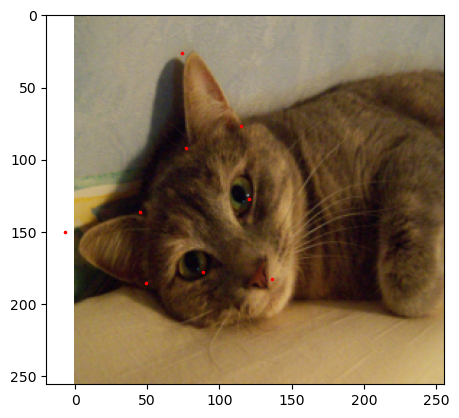

In [16]:
idx = 0
sample = {'image': test_dataset[idx], 'points': test_preds[idx]}
show_img_with_points(sample)

Очень даже хорошо получилось

#### Код для отправки посылки:

In [ ]:
tmp = pd.read_csv('train_labels.csv')
col = tmp.columns.values
col[-1] += 's'
submit = pd.DataFrame(columns=tmp.columns)


for i in range(len(test_dataset)):
    h, w = torchvision.io.read_image(os.path.join('images/images/test',test_dataset.get_image_name(i))).shape[1:]
    sample = {'image': test_dataset[i], 'points': test_preds[i]}
    sample = Rescaler((h, w))(sample)
    submit.loc[i] = list(sample['points'].flatten()) + [test_dataset.get_image_name(i)]

submit.to_csv('solve.csv', index=False)

### Conclusion (Выводы)

В этом разделе описываете полученные результаты и проводите анализ выполненной работы. 
Что получилось / не получилось и почему?

Получилось сделать аугментацию, написать свои датасеты и трансформеры. Поэксперементировал с разными сверточными архитектурами, которые подстроил под свою задачу. Не придумал как сделать подбор гиперпараметров по типу lr в оптимизаторе или max_lr в планировщеке lr. Пробовал провести lr range test используя PyTorch-Ignite, но он не дал каких-то адекватных результатов, поэтому я даже не оставил его в лабораторной. 